<div style="text-align: center;">
  <a href="https://cognitiveclass.ai/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="400">
  </a>
</div>


<h1 align=left><font size = 6>Lab: Land Classification: CNN-Transformer Integration evaluation </font></h1>
    
<h2 align=left><font size = 5>Vision Transformer (ViT) Model Evaluation </font></h2>


Estimated time: 90 minutes


# Introdution

This notebook presents an end-to-end workflow for importing, testing, and evaluating two Vision Transformer (ViT) models developed in Keras and PyTorch, respectively. 
The self-attention mechanism in the ViTs allows these models to learn complex and broad spatial dependencies, providing improved performance on a variety of vision tasks compared to traditional convolutional neural networks. However, the CNNs are adept in learning the local features very well and can be trained using relatively smaller datasets and is generally much more efficient in utilizing the computational resources, as compared to ViTs. A CNN-ViT hybrid architecture gains from both CNN and ViT model strengths, by getting local features extracted using CNNs, while the transformer part of the hybrid architecture can determine the global dependencies.

This lab focuses on model loading, prediction on sample data, and quantitative evaluation of the ViT models created using KEras and PyTorch. You'll explore the details of the framework-specific implementations, test the consistency of results, and gain practical experience comparing deep learning models across different Python ecosystems. 

Upon completion, you will have a thorough understanding of loading the CNN-ViT hybrid models testing workflow, key evaluation metrics, and how high-level architectural concepts translate into practical model evaluation using both Keras and PyTorch.


## Objectives

- Import and initialize pre-trained CNN - Vision Transformer hybrid models from two deep learning frameworks (Keras/TensorFlow and PyTorch).
- Prepare and preprocess sample image data for inference.
- Perform model inference and obtain prediction results from both models.
- Compute and compare core evaluation metrics.


## Table of Contents
1. [Dataset download, extraction and paths](#Dataset-download,-extraction-and-paths)
2. [Pre-trained model download](#Pre-trained-model-download)
3. [Package installation](#Package-installation)
4. [Library imports and setup](#Library-imports-and-setup)
5. [Fix random seed for reproducibility](#Fix-random-seed-for-reproducibility)
6. [Defining PyTorch model architecture](#Defining-PyTorch-model-architecture)
7. [Dataset path and hyperparameters](#Dataset-path-and-hyperparameters)
8. [PyTorch Dataloader](#PyTorch-Dataloader)
9. [--- PyTorch pre-trained ViT model loading ---](#----PyTorch-pre-trained-ViT-model-loading----)
10. [PyTorch model inference metrics](#PyTorch-model-inference-metrics)
11. [Keras model loading](#Keras-model-loading)
12. [--- Keras ViT pre-trained model loading ---](#----Keras-pre-trained-ViT-model-loading----)
13. [Define dataloader](#Define-dataloader)
14. [Collecting metrics for Keras-based CNN-ViT hybrid model](#Collecting-metrics-for-Keras-based-CNN-ViT-hybrid-model)
15. [Import the evaluation metrics](#Import-the-evaluation-metrics)
16. [Keras metrics reporting](#Keras-metrics-reporting)
17. [PyTorch metrics reporting](#PyTorch-metrics-reporting)
18. [ROC curve plotting](#ROC-curve-plotting)
19. [Comparing model performance](#Comparing-model-performance)
20. [Summary and discussion](#Summary-and-discussion)
21. [Conclusion](#Conclusion)


## Dataset download, extraction and paths
We begin by downloading the dataset for evaluation of the models.
Here, you declare:
1. The dataset URL from where the dataset would be downloaded.
2. The dataset downloading primary function, based on `skillsnetwork` library.
3. The dataset fallback downloading function, based on regular `http` downloading functions.


### Define root directory and download `url`

First, you define the root directory where all the data would be downloaded and extracted.
Here, the `dataset_url` is assigned a direct link to a tar archive hosted on IBM's cloud storage. This URL points to the satellite image dataset used for land classification tasks. Using a cloud-based URL ensures accessibility without local storage dependencies. This setup facilitates automated downloads later in the notebook. 

If dealing with large datasets, monitor download times and implement retry mechanisms for robustness. This variable is key for the subsequent download functions, linking external data to the local workflow.


In [1]:
data_dir = "."

In [2]:
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4Z1fwRR295-1O3PMQBH6Dg/images-dataSAT.tar"

### Data download
We begin by downloading the dataset for evaluation of the models.
Here, you declare:
1. The dataset downloading primary function, based on `skillsnetwork` library.
2. The dataset fallback downloading function, based on regular `http` downloading functions.
3. Download the dataset


In [3]:
import os
import skillsnetwork

def check_skillnetwork_extraction(extract_dir):
    """Check if the environment allows symlink creation for download/extraction."""
    symlink_test = os.path.join(extract_dir, "symlink_test")
    if not os.path.exists(symlink_test):
        os.symlink(os.path.join(os.sep, "tmp"), symlink_test)
        print("Write permissions available for downloading and extracting the dataset tar file")
        os.unlink(symlink_test)

async def download_tar_dataset(url, tar_path, extract_dir):
    """Download and extract dataset tar file asynchronously."""
    if not os.path.exists(tar_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(tar_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{tar_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Dataset tar file already exists at: {tar_path}")
    import tarfile
    with tarfile.open(tar_path, 'r:*') as tar_ref:
        tar_ref.extractall(path=extract_dir)
        print(f"Successfully extracted to '{extract_dir}'.")

try:
    check_skillnetwork_extraction(data_dir)
    await skillsnetwork.prepare(url=dataset_url, path=data_dir, overwrite=True)
except Exception as e:
    print(e)
    print("Primary download/extraction method failed.")
    print("Falling back to manual download and extraction...")
    import tarfile
    import httpx
    from pathlib import Path
    file_name = Path(dataset_url).name
    tar_path = os.path.join(data_dir, file_name)
    await download_tar_dataset(dataset_url, tar_path, data_dir)

Write permissions available for downloading and extracting the dataset tar file


  0%|          | 0/6003 [00:00<?, ?it/s]

Saved to '.'


## Pre-trained model download 

Now, define an asynchronous function to download model files from given URLs, if they are not already present locally. 
You use `httpx` for asynchronous HTTP requests with error handling.


In [4]:
async def download_model(url, model_path):
    if not os.path.exists(model_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(model_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{model_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Model file already downloaded at: {model_path}")

## Model paths and download

In the cell below, you define the file paths and URLs for the Keras and PyTorch models and download them using the `download_model` function defined above.


In [5]:
data_dir = "."

keras_model_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/7uNMQhNyTA8qSSDGn5Cc7A/keras-cnn-vit-ai-capstone.keras"
keras_model_name = "keras_cnn_vit_ai_capstone.keras"
keras_model_path = os.path.join(data_dir, keras_model_name)

pytorch_state_dict_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/rFBrDlu1NNcAzir5Uww8eg/pytorch-cnn-vit-ai-capstone-model-state-dict.pth"
pytorch_state_dict_name = "pytorch_cnn_vit_ai_capstone_model_state_dict.pth"
pytorch_state_dict_path = os.path.join(data_dir, pytorch_state_dict_name)

await download_model(keras_model_url, keras_model_path)
await download_model(pytorch_state_dict_url, pytorch_state_dict_path)

Successfully downloaded './keras_cnn_vit_ai_capstone.keras'.
Successfully downloaded './pytorch_cnn_vit_ai_capstone_model_state_dict.pth'.


## Package installation

Install the required basic Python packages. 


In [6]:
%%time
%%capture captured_output
# %pip install numpy==1.26
# %pip install matplotlib==3.9.2
# %pip install skillsnetwork

CPU times: user 461 μs, sys: 14 μs, total: 475 μs
Wall time: 477 μs


### Install PyTorch library


In [7]:
%%time
# %pip install torch==2.7.0

CPU times: user 1 μs, sys: 1e+03 ns, total: 2 μs
Wall time: 2.86 μs


### Install PyTorch helper libraries


In [8]:
%%time
# %pip install torchvision==0.22

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 4.05 μs


### Install tensorflow library for Keras


In [9]:
%%time
# %pip install tensorflow==2.19

CPU times: user 1 μs, sys: 0 ns, total: 1 μs
Wall time: 3.1 μs


### Install SkLearn library for evaluation metrics


In [10]:
%%time
# %pip install scikit-learn==1.7.0

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 3.1 μs


## Library imports and setup

Import essential libraries for data manipulation, visualization, and suppresses warnings for cleaner notebook output.


In [11]:
%%time
import warnings
warnings.filterwarnings('ignore')

import os
import time
import httpx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


CPU times: user 1.71 s, sys: 274 ms, total: 1.98 s
Wall time: 330 ms


### TensorFlow/Keras library imports

These imports set the environment variables to reduce TensorFlow logging noise and imports Keras modules for model building and training. They detect GPU availability for device assignment.


In [12]:
%%time
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

gpu_list = tf.config.list_physical_devices('GPU')
device = "gpu" if gpu_list != [] else "cpu"
print(f"TensorFlow {tf.__version__}  |  GPUs found: {tf.config.list_physical_devices('GPU')}")

TensorFlow 2.16.2  |  GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPU times: user 1.89 s, sys: 349 ms, total: 2.24 s
Wall time: 3.14 s


### PyTorch library imports

Import core PyTorch modules for model building, optimization, data loading, and functional utilities.


In [13]:
%%time
import torch
import torch.nn as nn
#import torch.optim as optim
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import  random_split
import torch.nn.functional as F

print("Imported libraries")

Imported libraries
CPU times: user 1.06 s, sys: 168 ms, total: 1.23 s
Wall time: 1.51 s


## Fix random seed for reproducibility

Define `set_seed` to ensure reproducibility across Python, NumPy, TensorFlow, and PyTorch by seeding random generators and enabling deterministic cuDNN. 

Set `SEED` to 7331. This is useful for consistent results in stochastic processes like training or inference.


In [14]:
#====================
def set_seed(seed: int = 42) -> None:
    """Seed Python, NumPy, tensorflow, and PyTorch (CPU & all GPUs) and
    make cuDNN run in deterministic mode."""
    # ---- Python and NumPy -------------------------------------------
    random.seed(seed)
    np.random.seed(seed)

    # ---- Tensorflow -------------------------------------------------
    tf.random.set_seed(seed)

    # ---- PyTorch (CPU  &  GPU) --------------------------------------
    torch.manual_seed(seed)            
    torch.cuda.manual_seed_all(seed)   

    # ---- cuDNN: force repeatable convolutions -----------------------
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark     = False 

#====================
SEED = 7331
set_seed(SEED)
print(f"Global seed set to {SEED} - Processes are now deterministic.")

Global seed set to 7331 - Processes are now deterministic.


## Model paths 
Check for the existence of the Keras and PyTorch model files. This ensures models are accessible before loading, preventing runtime errors. Use absolute paths for reliability.


In [15]:
if not os.path.exists(keras_model_path):
    print("Unable to find the Keras model at give path. Please check...")
else:
    print(f"Found the pre-trained Keras model:\n{keras_model_name} --at------> {keras_model_path}")

if not os.path.exists(pytorch_state_dict_path):
    print("Unable to find the PyTorch model at give path. Please check...")
else:
    print(f"Found the pre-trained PyTorch model:\n{pytorch_state_dict_name} --at------> {pytorch_state_dict_path}")

Found the pre-trained Keras model:
keras_cnn_vit_ai_capstone.keras --at------> ./keras_cnn_vit_ai_capstone.keras
Found the pre-trained PyTorch model:
pytorch_cnn_vit_ai_capstone_model_state_dict.pth --at------> ./pytorch_cnn_vit_ai_capstone_model_state_dict.pth


## Defining PyTorch model architecture
In this cell, you will define the PyTorch CNN-ViT model architegcture, exactly as defined during the model training. You define the classes for CNN feature extractor, patch embedding, multi-head self-attention, transformer block, ViT, and CNN-ViT hybrid. 

The `evaluate` function computes loss and accuracy. This architecture combines CNN local features with ViT global attention. 

Parameters like depth and heads are configurable, and defined same as during training.


In [16]:
#====================
class ConvNet(nn.Module):
    ''' 
    Class to define the architecture same as the imported pre-trained CNN model
    '''
    def __init__(self, num_classes: int):
        super().__init__()
        # -------- convolutional feature extractor --------
        self.features = nn.Sequential(
            nn.Conv2d(3, 32,  kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64,  kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, kernel_size=5, padding=2), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
        )

        # -------- global pooling + classifier head --------
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(nn.Flatten(),                           # flatten feature map of dimensions (1024 × 1 × 1) to 1024
                                        nn.Linear(1024, 2048), nn.ReLU(inplace=True), nn.BatchNorm1d(2048), nn.Dropout(0.4), 
                                        nn.Linear(2048, num_classes)
                                       )

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        return self.features(x)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.forward_features(x)   # features, dimensions:(B, 1024, H', W')
        x = self.pool(x)               # global-average-pooling, dimensions: (B, 1024, 1, 1)
        x = self.classifier(x)         # classifier, dimensions: (B, num_classes)
        return x

#====================
class PatchEmbed(nn.Module):
    def __init__(self, input_channel=1024, embed_dim=768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1)  # 1×1 conv
    
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1, 2)  # (B,L,D)
        return x

#====================
class MHSA(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)
    
    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2)  # (B, heads, N, d)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))

#====================
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio=4., dropout=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = nn.Sequential(
                                    nn.Linear(dim, int(dim * mlp_ratio)),
                                    nn.GELU(), nn.Dropout(dropout),
                                    nn.Linear(int(dim * mlp_ratio), dim),
                                    nn.Dropout(dropout))
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

#====================
class ViT(nn.Module):
    def __init__(self, in_ch=1024, num_classes=2,
                 embed_dim=768, depth=6, heads=8,
                 mlp_ratio=4., dropout=0.1, max_tokens=50):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim)           # 1×1 conv
        self.cls   = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos   = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                          # x: (B,C,H,W)
        x = self.patch(x)                          # (B,L,D)
        B, L, _ = x.shape
        cls = self.cls.expand(B, -1, -1)           # (B,1,D)
        x = torch.cat((cls, x), 1)                 # (B,L+1,D)
        x = x + self.pos[:, :L + 1]                # match seq-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])       # CLS token

#====================
class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=2, embed_dim=768, depth=6, heads=8):
        super().__init__()
        self.cnn = ConvNet(num_classes)            # load weights later
        self.vit = ViT(num_classes=num_classes,
                       embed_dim=embed_dim,
                       depth=depth,
                       heads=heads)
    
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))

#====================
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct  += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)# Set device

## Dataset path and hyperparameters
Here, you set the dataset path and hyperparameters like image size, channels, batch size, classes, and labels. These are used for data loading and model configuration. Consistent dimensions ensure compatibility with model inputs.


## Task 1: Define the dataset directory, dataloader and model hyperparameters. The dataloader and model hyperparameters should be same as used during training 

- Define the `dataset_path`

- Define **hyperparameters common dataloader**
    - `img_w`, `img_h = 64, 64`
    - `batch_size = 128`
    - `num_classes = 2`
    - `agri_class_labels = ["non-agri", "agri"]`

  
- Define **hyperparameters for PyTorch CNN-Vit Hybrid model**. The values have to same as those used while training the hybrid model. 
    - `depth = 3`
    - `attn_heads = 6`
    - `embed_dim = 768`



In [17]:
## Please use the space below to write your answer

dataset_path = os.path.join(data_dir, "images_dataSAT")

img_w, img_h = 64, 64
batch_size=128
num_classes = 2
agri_class_labels = ["non-agri", "agri"]
depth=3
attn_heads=6
embed_dim=768

Double-click **here** for the solution.
<!--
dataset_path = os.path.join(data_dir, "images_dataSAT")

# hyperparameters common dataloader
img_w, img_h = 64, 64
batch_size = 128
num_classes = 2
agri_class_labels = ["non-agri", "agri"]

# hyperparameters for PyTorch CNN-Vit Hybrid model
depth = 3
attn_heads = 6
embed_dim = 768
-->


### PyTorch Dataloader
Defines transforms for resizing, tensor conversion, and normalization (ImageNet means/std). 

Loads dataset with ImageFolder and creates DataLoader for batching without shuffling for evaluation.


In [18]:
train_transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder(dataset_path, transform=train_transform)
test_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

## Task 2: Instantiate PyTorch model
Check the availability of CUDA device and set the `device` parameter accordingly.

Based on the `CNN_ViT_Hybrid` function, instantiate the PyTorch model and move the model to the available `device`

In this cell, you will:
1. instantiate the PyTorch CNN_ViT_Hybrid with the previously declared model parameters
3. detect the device for model inference
 


In [19]:
## Please use the space below to write your answer
device = "mps"
pytorch_model = CNN_ViT_Hybrid(
    num_classes = 2,
    heads=attn_heads, 
    depth=depth,
    embed_dim=embed_dim
).to(device)

Double-click **here** for the solution.
<!--
# Check device availability
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model instance
pytorch_model = CNN_ViT_Hybrid(num_classes=num_classes,
                      heads=attn_heads,
                      depth=depth,
                      embed_dim=embed_dim).to(device)
-->


In [20]:
print(f"Evaluating the PyTorch model on {device}")

Evaluating the PyTorch model on mps


### --- PyTorch pre-trained ViT model loading ---
In this cell, you will load the PyTorch model state dict with **`strict=False`** for flexibility.

Thus, you prepare the model for inference.


In [22]:
# Load pre-trained CNN-ViT hybrid model weights 
if device=="cpu":
    map_location=torch.device("cpu")
elif device=="mps":
    map_location=torch.device("mps")
else:
    map_location=torch.device("cuda")

pytorch_model.load_state_dict(torch.load(pytorch_state_dict_path, map_location=map_location), strict=False)
print("Loaded model state dict, now getting predictions")

Loaded model state dict, now getting predictions


### PyTorch model inference metrics

Now, you perform:
1. inference on test_loader
2. collecte prediction, labels, and probabilities (for class 1)
3. Uses no_grad for efficiency and eval mode
4. Use tqdm to show progress.
5. Move the data to the training device (CPU/GPU).


In [23]:
%%time
all_preds_pytorch = []
all_labels_pytorch = []
all_probs_pytorch = []

pytorch_model.eval()
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Step")):
#    for images, labels in test_loader:
        images = images.to(device)
        outputs = pytorch_model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)[:, 1]  # probability for class 1
        all_probs_pytorch.extend(probs.cpu())
        all_preds_pytorch.extend(preds.cpu().numpy().flatten())
        all_labels_pytorch.extend(labels.numpy())

Step: 100%|██████████| 47/47 [00:08<00:00,  5.45it/s]

CPU times: user 1.23 s, sys: 476 ms, total: 1.7 s
Wall time: 8.62 s


## Keras model loading

To load the Keras based CNN-ViT hybrid model, you will

- define **custom Keras layers** with serialization for model saving/loading for:
    - `position embedding`
    - `transformer block`

This step is essential for reconstructing the ViT architecture in Keras.


In [24]:
# Positional embedding that Keras can track
@tf.keras.utils.register_keras_serializable(package="Custom")
class AddPositionEmbedding(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super(AddPositionEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim   = embed_dim
        self.pos = self.add_weight(
            name="pos_embedding",
            shape=(1, num_patches, embed_dim),
            initializer="random_normal",
            trainable=True)

    def call(self, tokens):
        return tokens + self.pos

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim":   self.embed_dim,
        })
        return {**config}

# One Transformer encoder block
@tf.keras.utils.register_keras_serializable(package="Custom")
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, mlp_dim=2048, dropout=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim   = mlp_dim
        self.dropout   = dropout
        self.mha  = layers.MultiHeadAttention(num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])

    def call(self, x):
        x = self.norm1(x + self.mha(x, x))
        return self.norm2(x + self.mlp(x))

    # ---- NEW ----
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim":  self.embed_dim,
            "num_heads":  self.num_heads,
            "mlp_dim":    self.mlp_dim,
            "dropout":    self.dropout,
        })
        return {**config}

### --- Keras pre-trained ViT model loading ---

Here, you will load the pre-trained Keras model using **`load_model`**, providing **custom objects** for deserialization of user-defined layers. This enables inference with the hybrid model.


In [25]:
# ------------------- load CNN-ViT hybrid model ------------------
keras_model = load_model(keras_model_name,
                         custom_objects={
                         "AddPositionEmbedding": AddPositionEmbedding,
                         "TransformerBlock":     TransformerBlock
                          })

### Define dataloader

In this cell, you create an ImageDataGenerator for rescaling and a generator for flowing images from directory, matching PyTorch setup for consistent evaluation.


In [26]:
datagen = ImageDataGenerator(rescale=1./255)
prediction_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 6000 images belonging to 2 classes.


### Collecting metrics for Keras-based CNN-ViT hybrid model
Now, run the inference of the Keras-based CNN-ViT hybrid model and collect the evaluation metrics.


In [27]:
%%time

all_probs_keras = keras_model.predict(prediction_generator, verbose=1)
all_preds_keras = np.argmax(all_probs_keras, axis=1)
all_labels_keras = prediction_generator.classes

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step
CPU times: user 2.23 s, sys: 1.12 s, total: 3.35 s
Wall time: 7.12 s


## Import the evaluation metrics

Here you define the functions to compute and print classification metrics including accuracy, precision, recall, F1 score, ROC-AUC, confusion matrix, and log loss. These functions support both Keras and PyTorch model outputs.


In [29]:
%%time
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve, 
                             roc_auc_score,
                             log_loss,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )
from sklearn.preprocessing import label_binarize

# define a function to get the metrics comprehensively
def model_metrics(y_true, y_pred, y_prob, class_labels):
    y_prob = np.array(y_prob)
    if len(y_prob.shape)<2:
        roc_score = roc_auc_score(y_true, y_prob)
    elif len(y_prob.shape)==2:
        roc_score = roc_auc_score(y_true, y_prob[:,1])
    else:
        roc_score = np.nan
    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'Loss': log_loss(y_true, y_prob),
               'F1 Score': f1_score(y_true, y_pred),
               'ROC-AUC': roc_score,
               'Confusion Matrix': confusion_matrix(y_true, y_pred),
               'Classification Report': classification_report(y_true, y_pred, target_names=class_labels, digits=4),
               "Class labels": class_labels
              }
    return metrics

#function to print the metrics
def print_metrics(y_true, y_pred, y_prob, class_labels, model_name):
    metrics = model_metrics(y_true, y_pred, y_prob, class_labels)
    
    print(f"Evaluation metrics for the \033[1m{model_name}\033[0m")
    print(f"Accuracy: {'':<1}{metrics['Accuracy']:.4f}")
    if metrics["ROC-AUC"] != np.nan:
        print(f"ROC-AUC: {'':<2}{metrics['ROC-AUC']:.4f}")
    print(f"Loss: {'':<5}{metrics['Loss']:.4f}\n")
    print(f"Classification report:\n\n  {metrics['Classification Report']}")
    print("========= Confusion Matrix =========")
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"],
                                  display_labels=metrics["Class labels"])

    disp.plot()
    plt.show()


CPU times: user 75.8 ms, sys: 17.6 ms, total: 93.5 ms
Wall time: 116 ms


## Keras metrics reporting


## Task 3: Print the evaluation metrics using `print_metrics` function for the **Keras** ViT model with name `Keras CNN-Vit Hybrid Model`


Evaluation metrics for the Keras CNN-Vit Hybrid Model
Accuracy:  0.9958
ROC-AUC:   0.9998
Loss:      0.0530

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9927    0.9990    0.9958      3000
        agri     0.9990    0.9927    0.9958      3000

    accuracy                         0.9958      6000
   macro avg     0.9959    0.9958    0.9958      6000
weighted avg     0.9959    0.9958    0.9958      6000

========= Confusion Matrix =========


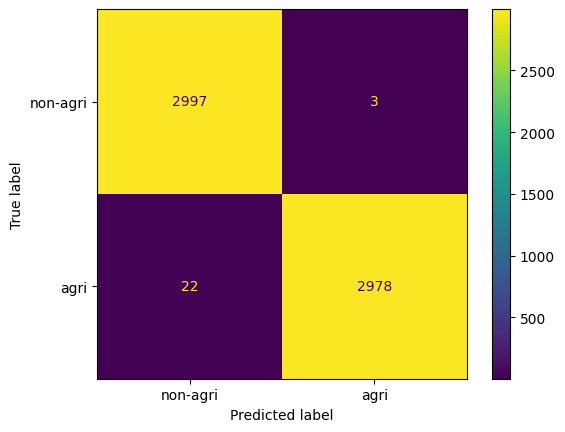

In [31]:
print_metrics(y_true = all_labels_keras, y_pred=all_preds_keras, y_prob = all_probs_keras, class_labels=agri_class_labels, model_name = "Keras CNN-Vit Hybrid Model")


Double-click **here** for the solution.
<!--
print_metrics(y_true = all_labels_keras,
              y_pred = all_preds_keras,
              y_prob = all_probs_keras,
              class_labels = agri_class_labels,
              model_name = "Keras CNN-Vit Hybrid Model"
             )
-->


## PyTorch metrics reporting


## Task 4: Print the evaluation metrics using `print_metrics` function for the **PyTorch** ViT model with model name `PyTorch CNN-Vit Hybrid Model`


Evaluation metrics for the Pytorch CNN-Vit Hybrid Model
Accuracy:  0.9990
ROC-AUC:   1.0000
Loss:      0.0047

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9990    0.9990    0.9990      3000
        agri     0.9990    0.9990    0.9990      3000

    accuracy                         0.9990      6000
   macro avg     0.9990    0.9990    0.9990      6000
weighted avg     0.9990    0.9990    0.9990      6000

========= Confusion Matrix =========


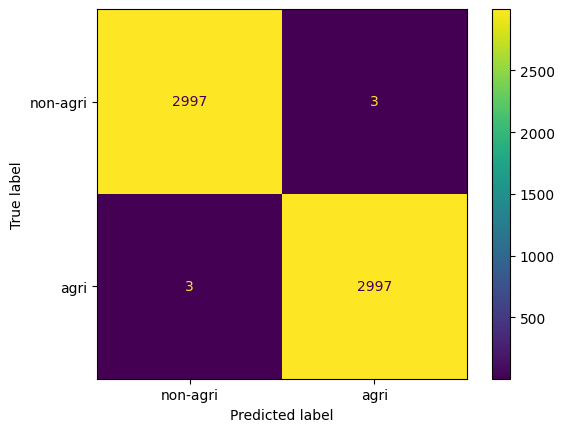

In [32]:
## Please use the space below to write your answer
print_metrics(y_true = all_labels_pytorch, y_pred=all_preds_pytorch, y_prob = all_probs_pytorch, class_labels=agri_class_labels, model_name = "Pytorch CNN-Vit Hybrid Model")



Double-click **here** for the solution.
<!--
print_metrics(y_true = all_labels_pytorch,
              y_pred = all_preds_pytorch,
              y_prob = np.array(all_probs_pytorch),
              class_labels = agri_class_labels,
              model_name = "PyTorch CNN-Vit Hybrid Model"
             )
-->


## ROC curve plotting

First, define a function to plot ROC curves for binary or multi-class classification using scikit-learn's `roc_curve` and `roc_auc_score`. It handles both single-class and multi-class cases by binarizing labels if needed.

Next, plot the ROC curves for both the models.


In [33]:

def plot_roc(y_true, y_prob, model_name):
    n_classes = y_prob.shape[1] if y_prob.ndim > 1 else 1
    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    else:
        y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            auc = roc_auc_score(y_true_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f'{model_name} class {i} (AUC = {auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

### ROC curve plotting for both models

Plot the ROC curves for both Keras and PyTorch models on the same figure for visual performance comparison.


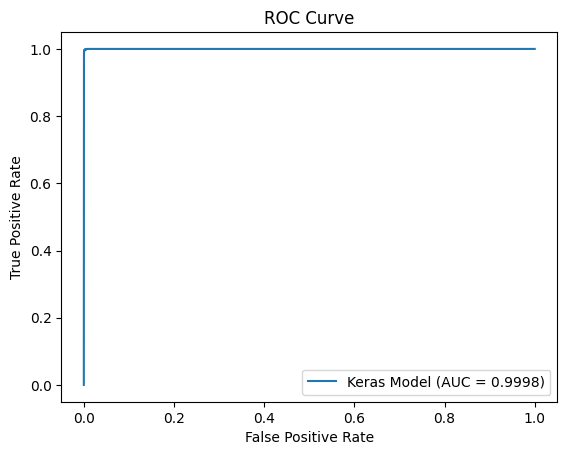

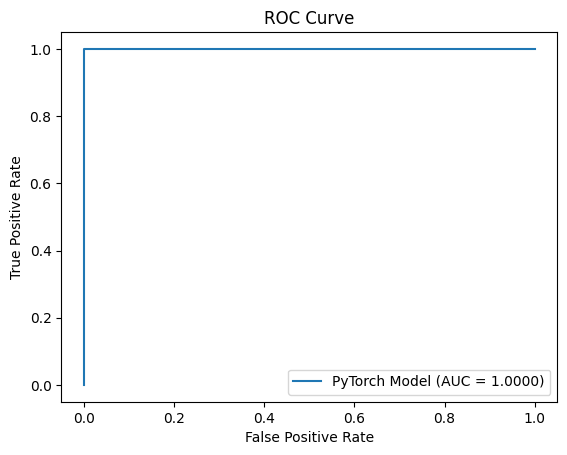

In [34]:
plot_roc(np.array(all_labels_keras), np.array(all_probs_keras[:, 1]), "Keras Model")
plt.show()
plot_roc(np.array(all_labels_pytorch), np.array(all_probs_pytorch), "PyTorch Model")
plt.show()

## Comparing model performance

Now compare the performance of different models to understand which model would be the best performer for your land classification task.
Computed metrics for both models are used to generate a comparison table for key scores. This facilitates quick performance assessment between frameworks.


In [35]:
# get the Keras model performance metrics
metrics_keras = model_metrics(all_labels_keras, all_preds_keras, all_probs_keras, agri_class_labels)

# get the PyTorch model performance metrics
metrics_pytorch = model_metrics(all_labels_pytorch, all_preds_pytorch, all_probs_pytorch, agri_class_labels)


# Display the comparison of metrics
print("{:<18} | {:<15} {:<15}".format('\033[1m'+ 'Metric' + '\033[0m',
                                    'Keras Model', 
                                    'PyTorch Model'))
print(("".join(["-" for _ in range(43)])))
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for k in metrics_list:
    print("{:<18} | {:<15.4f} {:<15.4f}".format('\033[1m'+k+'\033[0m',
                                              metrics_keras[k],
                                              metrics_pytorch[k]))

Metric     | Keras Model     PyTorch Model  
-------------------------------------------
Accuracy   | 0.9958          0.9990         
Precision  | 0.9990          0.9990         
Recall     | 0.9927          0.9990         
F1 Score   | 0.9958          0.9990         
ROC-AUC    | 0.9998          1.0000         


## Summary and discussion

This notebook showcased a framework-agnostic workflow for importing, testing, and evaluating Vision Transformer models built in both Keras and PyTorch. By running the same input through each model, we examined the compatibility of results and gained practical experience handling architectural and data format variations.

Key insights include the criticality of input format alignment, the subtle differences in model serialization/loading, and the framework-induced variations in prediction outputs. For a more robust evaluation, repeat this process with a labeled validation dataset, compute further metrics (precision, recall, F1-score), and systematically analyze speed and resource usage.



## Save and download the notebook for **final project** submission and evaluation

You will need to save and download the completed notebook for final project submission and evaluation. 
<br>For saving and downloading the completed notebook, please follow the steps given below:</br>

<font size = 4>  

1) **Complete** all the tasks and questions given in the notebook.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/nv4jHlPU5_R1q7ZJrZ69eg/DL0321EN-M1L1-Save-IPYNB-Screenshot-1.png" style="width:600px; border:0px solid black;">

2) **Save** the notebook.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/9-WPWD4mW1d-RV5Il5otTg/DL0321EN-M1L1-Save-IPYNB-Screenshot-2.png" style="width:600px; border:0px solid black;">

3) Identify and right click on the **correct notebook file** in the left pane.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/RUSRPw7NT6Sof94B7-9naQ/DL0321EN-M1L1-Save-IPYNB-Screenshot-3.png" style="width:600px; border:0px solid black;">

4) Click on **Download**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HHry4GT-vhLEcRi1T_LHGg/DL0321EN-M1L1-Save-IPYNB-Screenshot-4.png" style="width:600px; border:0px solid black;">

5) Download and **Save** the Jupyter notebook file on your computer **for final submission**.</style>
<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/hhsJbxc6R-T8_pXQGjMjvg/DL0321EN-M1L1-Save-IPYNB-Screenshot-5.png" style="width:600px; border:0px solid black;">
  </font>


## Conclusion
Congratulations! You have successfully completed this lab and now you have a good understanding about loading custom pre-trained models, for both Keras and PyTorch frameworks. Using these pre-trained models, you can now evaluate their performance and also infer unknown datasets.
I hope you have learnt to apply the key concepts of Keras/Pytorch based classifiers, both traditional CNNs and more advanced and state-of-the-art, CNN-ViT hybrid models. Using this knowledge, now you should be able to tackle a variety of real world image classification problems. Good luck!


<h2>Author</h2>

[Aman Aggarwal](https://www.linkedin.com/in/aggarwal-aman)

Aman Aggarwal is a PhD working at the intersection of neuroscience, AI, and drug discovery. He specializes in quantitative microscopy and image processing.


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2025-07-28  | 1.0  | Aman  |  Created the lab |

-->


© Copyright IBM Corporation. All rights reserved.
